In [127]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import os
from sys import platform
from importlib import reload
import sys
import reliability
from reliability.Fitters import Fit_Weibull_2P
import scipy.optimize as optimization
sys.path.append('../../../../')
import stlstuff as sls
import imagestuff as ims
import statstuff as sts
import retrievestuff as rs

In [128]:
%matplotlib notebook

The next cell has parameters that might change from crystal to crystal

In [129]:
# Loading in the compressed data
Segmentname = 'Segments1'
Flattenedfilename = Segmentname+'_compr_flat_filt.npz'; print(Flattenedfilename)

# Histogram accumulation
accumlist = [] # all

# Parameters for binning
Z2minforhist = 0.0
Z2maxforhist = .005
Z2offset = 0.0001
nbins_max = 10
levels = 3

Segments1_compr_flat_filt.npz


In [130]:
# # Loading in the compressed data
# Segmentname = 'Segments1'
# Flattenedfilename = Segmentname+'_compr_flat_filt.npz'; print(Flattenedfilename)

# # Histogram accumulation
# accumlist = [12,13,14,15,16,17,18,19] # all

# # Parameters for binning
# Z2minforhist = 0.0
# Z2maxforhist = .011
# Z2offset = 0.0001
# nbins_max = 8
# levels = 3

In [131]:
# # Loading in the compressed data
# Segmentname = 'Segments2'
# Flattenedfilename = Segmentname+'_compr_flat_filt.npz'; print(Flattenedfilename)

# # Histogram accumulation
# accumlist = [] # all

# # Parameters for binning
# Z2minforhist = 0.0
# Z2maxforhist = .25
# Z2offset = 0.001
# nbins_max = 8
# levels = 3

In [132]:
# Derivative names
Roughnessfilename = Flattenedfilename[0:-4]+'_roughness.jpg'; print(Roughnessfilename)
flattenedfile = np.load(Flattenedfilename)
xgridtot = flattenedfile['xgridtot']
ygridtot = flattenedfile['ygridtot']
zgridtot = flattenedfile['zgridtot']
nsegments = (len(xgridtot)); print(nsegments)

# This folder
cwd = os.getcwd(); i = cwd.index('crystals'); case_and_folder = cwd[i+9:]; print(case_and_folder)

Segments1_compr_flat_filt_roughness.jpg
16
2020-06-24/Run 1/case1.1 (ablation roughening)


In [133]:
# Histogram accumulation
if len(accumlist)==0:
    accumlist = [i for i in range(nsegments)]
plotthisone = accumlist
print('Accumulating segments', accumlist)
print('Plotting segments', plotthisone)

# Parameters for binning
print('Z2 ranging from', Z2minforhist, 'to', Z2maxforhist)
print('Max number of bins specified is', nbins_max)
Ntot = np.size(zgridtot[0]) # Just using the first one for a size estimate
nbins_sturges = int(1+3.3*np.log10(Ntot)); print('Sturges rule says maxbins =', nbins_sturges)
nbins = np.min([nbins_max,nbins_sturges]); print('Using nbins = ', nbins)
Z2bins = np.linspace(Z2minforhist,Z2maxforhist,nbins); #print(Z2bins)
Z2theory = np.linspace(Z2minforhist,Z2maxforhist,50); Z2theory=Z2theory[1:] # This is for Weibull plots
print('Using levels =', levels, 'for uncertainty analysis')


Accumulating segments [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Plotting segments [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Z2 ranging from 0.0 to 0.005
Max number of bins specified is 10
Sturges rule says maxbins = 10
Using nbins =  10
Using levels = 3 for uncertainty analysis


In [134]:
# Arrays for accumulating 
counts_list = []
meanZ2_list = []
Z2flat_list = []

# First-guess for Weibull fitting (sigma2W, etaW)
x0 = np.array([.1,.9])

# This suppresses warnings when lots of graphics windows are open
import matplotlib
matplotlib.rc('figure', max_open_warning = 0)

# This is for when we want to show or suppress intermediate graphics and other output
Show_intermediate_graphics = False

# Looping over segments
for isegment in range(nsegments):

    # Pull out the next segment
    sollast = zgridtot[isegment]
    xgrid = xgridtot[isegment] 
    ygrid = ygridtot[isegment]
    Ny, Nx = np.shape(sollast); #print(sollast.shape)
    Ntot = np.size(sollast)
    dx = xgrid[0,1]-xgrid[0,0]; #print('dx =', dx)
    dy = ygrid[1,0]-ygrid[0,0]; #print('dy =', dy)

    # Get the probability distribution in Z2
    counts, bins, meanZ2, Z2flat, error = rs.getrhoofz2(sollast,dx,dy,Z2bins=Z2bins,levels=levels)
    print('meanZ2 = ', meanZ2)
    print('statsigma = ', np.sqrt(meanZ2))

    # Plot if we want
    if isegment in plotthisone:
        
        # Reporting
        print('')
        print('****Working on segment', isegment)
        
        # Graph the surface
        if Show_intermediate_graphics:
            fig1 = plt.figure()
            ax = fig1.add_subplot(111, projection='3d')
            ax.plot_surface(xgrid, ygrid, sollast)
            title = Flattenedfilename+' #'+str(isegment)
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_zlabel('z')
            ax.set_title(title)
            ax.view_init(azim=-120,elev=22)
        
        # Normalize the distribution function, report stats
        integral_rho = np.trapz(counts, bins)
        print ('std dev of height = ', np.std(sollast))
        print('integral = ', integral_rho)
        counts = counts/integral_rho
        error = error/integral_rho

        # This is for calculating the errors in fitting (and graphing)
        countsplus = counts+error; #print(countsplus)
        countsminus = counts**2/countsplus; print(countsminus)

        # Graph the probability
        if Show_intermediate_graphics:
            plt.figure()
            plt.semilogy(bins, counts, 'ok')
            plt.semilogy(bins, countsplus, '+k')
            plt.semilogy(bins, countsminus,'+k')
            plt.title(title)
            plt.xlabel(r'$Z^{2}$')
            plt.ylabel(r'$\rho$')
            plt.grid(True)

        # Eliminate entries greater than a threshold (not sure if this is necessary)
        ikeep = np.argwhere(Z2flat < Z2maxforhist)
        Z2flat_new = np.squeeze(Z2flat[ikeep])

        # Attempt a best-fit based on the raw data
        analysis = Fit_Weibull_2P(failures=Z2flat_new,show_probability_plot=False)
        etaW = analysis.beta; #print('analysis.beta=',analysis.beta)
        sigma2W = analysis.alpha; #print('analysis.alpha=',analysis.alpha)
        sigmaW = np.sqrt(sigma2W)
        print('Based on raw data: sigmaW, etaW = ', sigmaW, etaW)
        
        # Attempt a best-fit based on the bins
        errors = np.log(countsplus/counts); #print(errors)
        solution, solutionerror = optimization.curve_fit(sts.logWeibull, bins+Z2offset, np.log(counts),x0,sigma=errors)
        etaW = solution[1]
        sigma2W = solution[0]
        sigmaW = np.sqrt(sigma2W)
        print('Based on bins: sigmaW, etaW = ', sigmaW, etaW)
        
        # Graph the best-fit probability
        myWeibull = sts.Weibull(Z2theory,sigma2W,etaW)
        if Show_intermediate_graphics:
            plt.semilogy(Z2theory, myWeibull, 'b',label = 'Weibull with $\sigma_w$ =' + str(sigmaW)[0:5] + ' $\eta_w$ =' + str(etaW)[0:5])
            plt.legend()
        
    # Accumulate if we want
    if isegment in accumlist:
        counts_list.append(counts)
        meanZ2_list.append(meanZ2)
        Z2flat_list.append(Z2flat)

Original =  756
4 0 189 [ 6 11  8  7 11  4 10 10  6]
4 1 189 [10  5 10  9  4 11 11  7  5]
4 2 189 [10  8 11 10  5  7  6  5  5]
4 3 189 [ 9 12  6  7 13  2  5 11  9]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
meanZ2 =  0.01161658522062555
statsigma =  0.10778026359508289

****Working on segment 0
std dev of height =  0.2516663191780615
integral =  0.0004972804972804973
[195.29839934 177.95343483 188.62656611 190.40986853 141.06269915
  94.55819484 155.98884134 165.58321282 128.85985203]
Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Failures / Right censored: 286/0 (0% right censored) 

Parameter  Point Estimate  Standard Error   Lower CI   Upper CI
    Alpha      0.00260751     0.000104909 0.00240979 0.00282145
     Beta         1.53388        0.076653    1.39076    1.69172 

Goodness of fit    Value
 Log-likelihood  1473.51
           AICc -2942.97
            BIC  -2935.7
             AD  4.57244 

Based on raw data: sigmaW, etaW =  0.051

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Failures / Right censored: 533/0 (0% right censored) 

Parameter  Point Estimate  Standard Error   Lower CI   Upper CI
    Alpha      0.00187387      7.5795e-05 0.00173106 0.00202848
     Beta         1.12382       0.0398926    1.04829    1.20479 

Goodness of fit    Value
 Log-likelihood  2840.41
           AICc  -5676.8
            BIC -5668.26
             AD  3.57563 

Based on raw data: sigmaW, etaW =  0.04328827668577575 1.1238178991690884
Based on bins: sigmaW, etaW =  0.049740043592647734 0.9679062831891758
Original =  756
4 0 189 [37 28 16 18 19 13 12  7  5]
4 1 189 [46 21 20 15 16 12  8 11  6]
4 2 189 [41 28 22 13 16  5 14  9  2]
4 3 189 [39 27 16 17 17 20  7 10  5]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
meanZ2 =  0.0026951292349854414
statsigma =  0.05191463411202511

****Working on segment 10
std dev of height =  0.05464610305693136
integral =  0.00047419992808342323
[499.31385

Original =  756
4 0 189 [59 30 25  8 10  8  8  3  7]
4 1 189 [60 33 18  9 14  8  8  4  5]
4 2 189 [60 30 18 11  8  5 15  5  5]
4 3 189 [58 25 27 12  9 11  3  9  4]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
meanZ2 =  0.0024214828397131497
statsigma =  0.04920856469877118
integral =  0.00044215893108298166


<IPython.core.display.Javascript object>


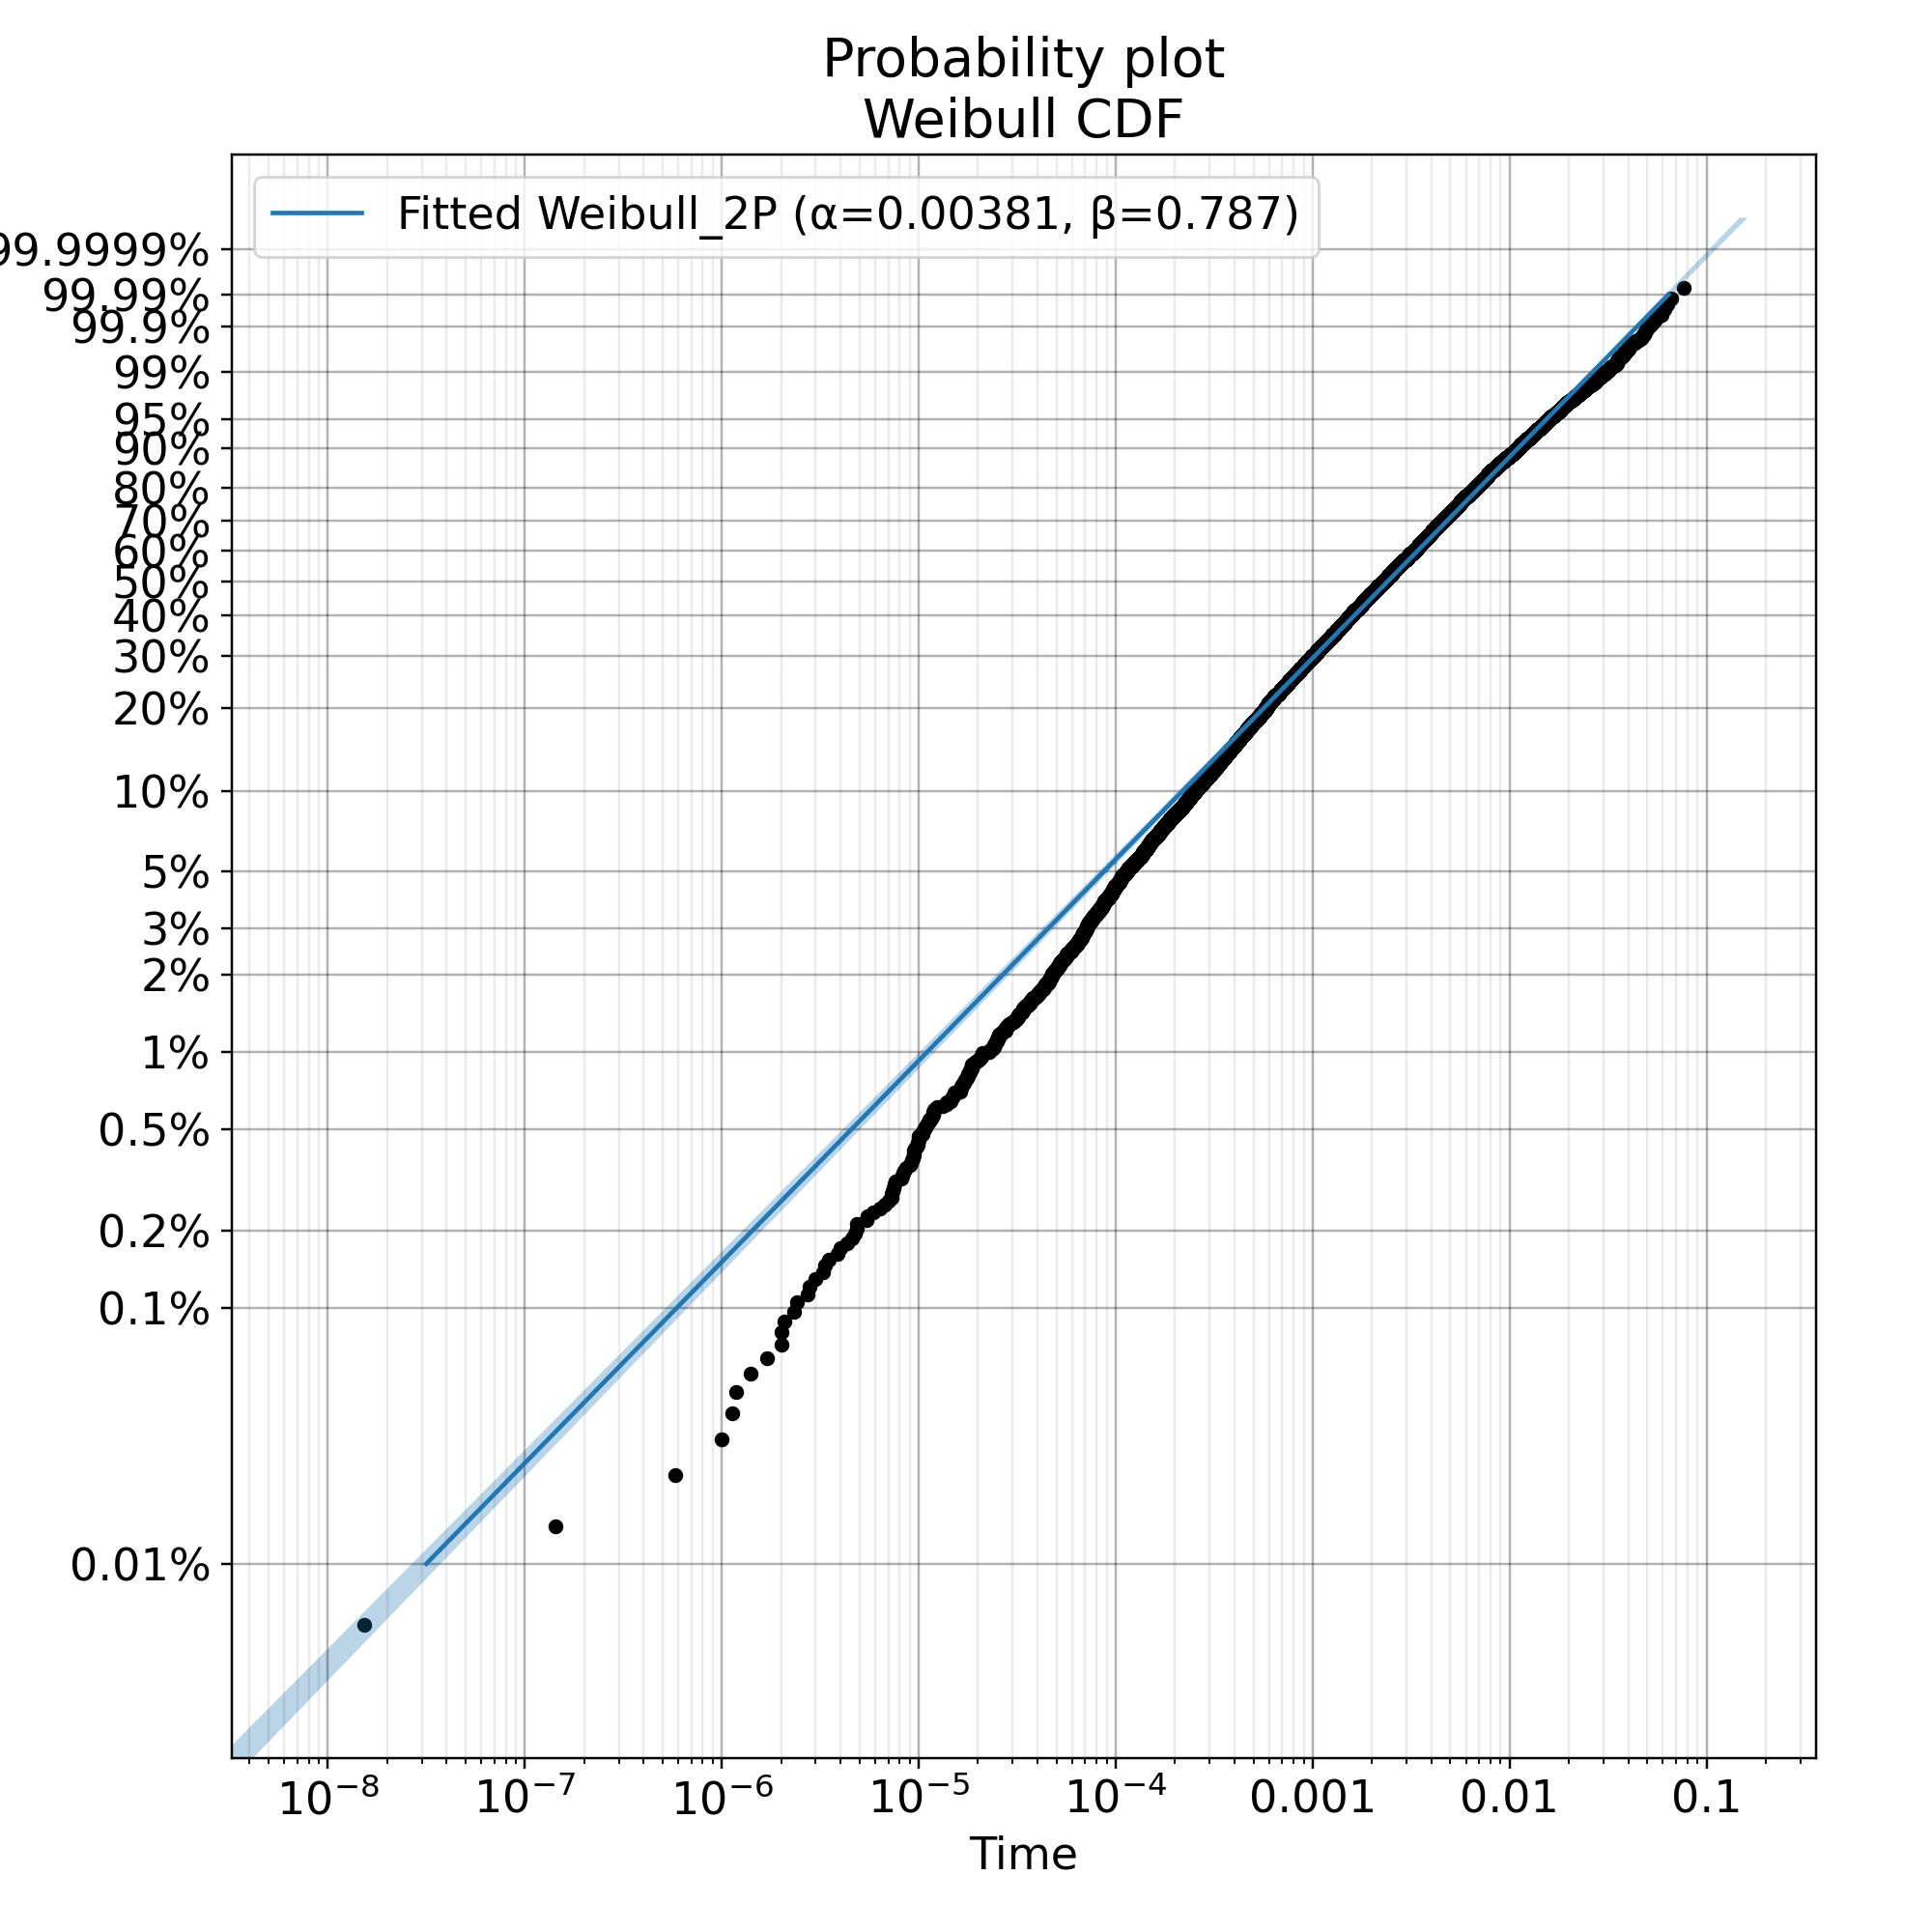

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Failures / Right censored: 12096/0 (0% right censored) 

Parameter  Point Estimate  Standard Error   Lower CI   Upper CI
    Alpha       0.0038099     4.64463e-05 0.00371995 0.00390203
     Beta        0.787236      0.00545683   0.776613   0.798004 

Goodness of fit   Value
 Log-likelihood 54207.5
           AICc -108411
            BIC -108396
             AD 9.85538 

analysis.beta= 0.787236063123398
analysis.alpha= 0.0038098992254372898
Based on raw data: sigmaW, etaW =  0.06172438112640166 0.787236063123398


In [135]:
# Sum up the accumulated information
Z2flat_total = []
for i in Z2flat_list:
    for j in i:
        Z2flat_total.append(j)
Z2flat_total = np.array(Z2flat_total)
Z2flat_new = np.squeeze(Z2flat_total)

# Get the probability distribution in Z2
counts, bins, meanZ2, error = rs.getrhoofz2flat(Z2flat,nbins,Z2bins,levels)
print('meanZ2 = ', meanZ2)
print('statsigma = ', np.sqrt(meanZ2))

# Normalize the distribution function
integral_rho = np.trapz(counts, bins)
print('integral = ', integral_rho)
counts = counts/integral_rho
error = error/integral_rho
countsplus = counts+error; #print(countsplus)
countsminus = counts**2/countsplus; #print(countsminus)

# Attempt a best-fit based on the raw data
plt.figure()
analysis = Fit_Weibull_2P(failures=Z2flat_new)
etaW = analysis.beta; print('analysis.beta=',analysis.beta)
sigma2W = analysis.alpha; print('analysis.alpha=',analysis.alpha)
sigmaW = np.sqrt(sigma2W)
print('Based on raw data: sigmaW, etaW = ', sigmaW, etaW)

In [136]:
# Attempt a best-fit based on the bins
errors = np.log(countsplus/counts); #print(errors)
solution, solutionerror = optimization.curve_fit(sts.logWeibull, bins+Z2offset, np.log(counts),x0,sigma=errors)
etaW = solution[1]
sigma2W = solution[0]
sigmaW = np.sqrt(sigma2W)
print('Based on bins: sigmaW, etaW = ', sigmaW, etaW)

Based on bins: sigmaW, etaW =  0.03888271345384464 0.767962428877191


<IPython.core.display.Javascript object>


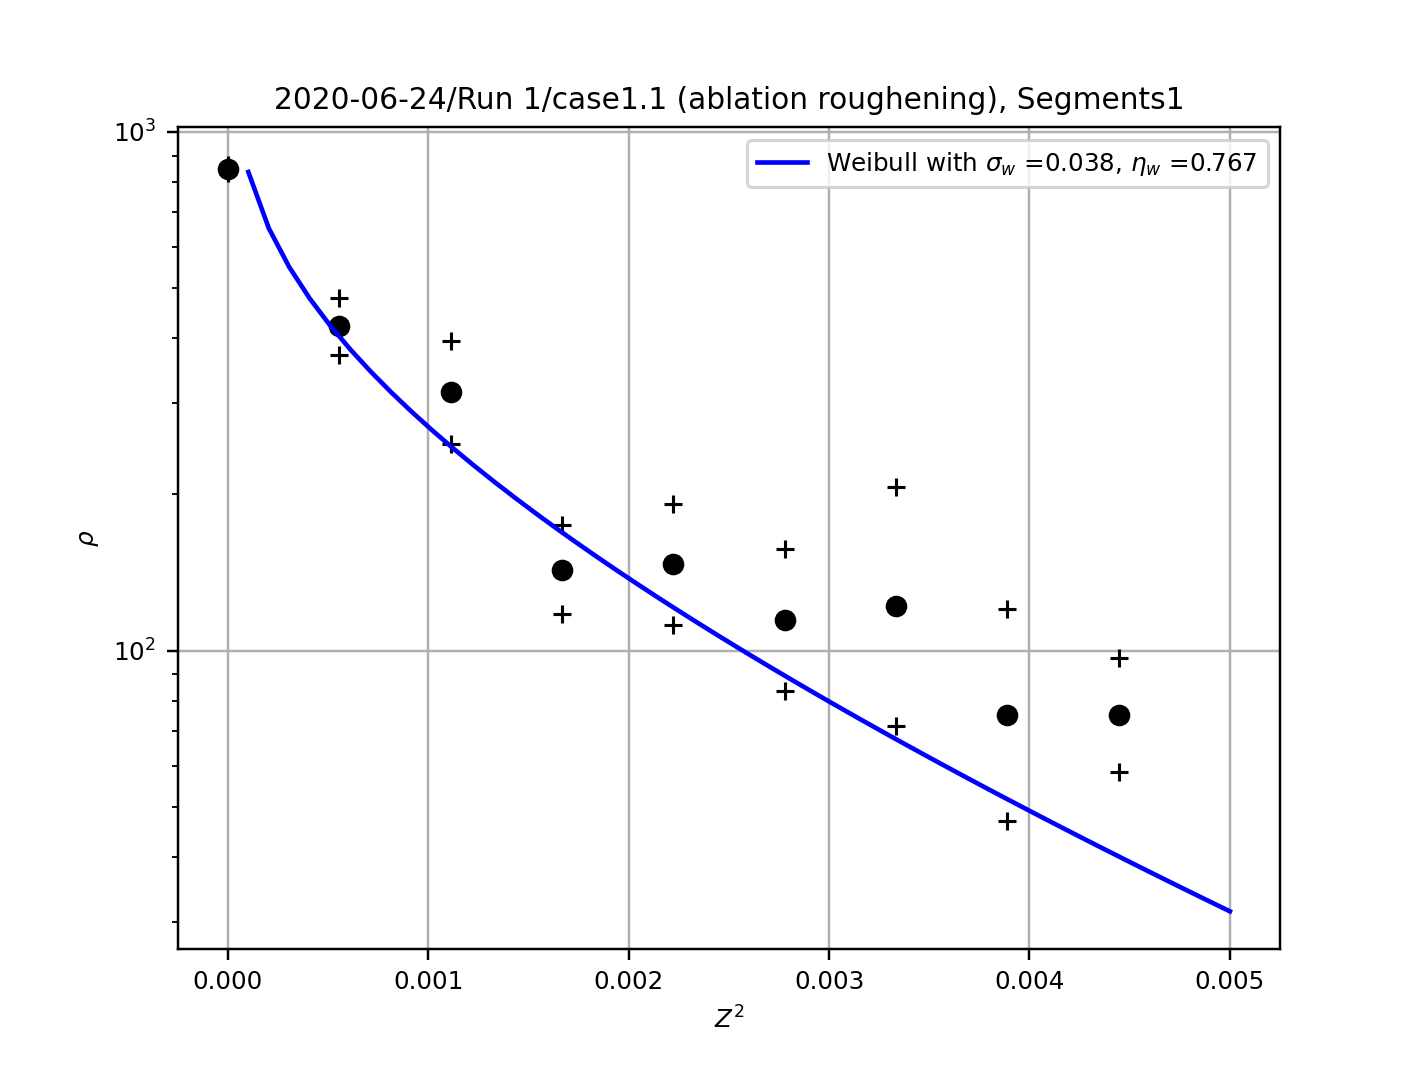

In [140]:
# Graph the probability
plt.figure()
fontsize = 8
plt.rcParams.update({'font.size': fontsize})
plt.semilogy(bins, counts, 'ok')
plt.semilogy(bins, countsplus, '+k')
plt.semilogy(bins, countsminus,'+k')
plt.title(case_and_folder + ', ' + Segmentname)
plt.xlabel(r'$Z^{2}$')
plt.ylabel(r'$\rho$')
plt.grid(True)

# Graph the best-fit probability
myWeibull = sts.Weibull(Z2theory,sigma2W,etaW)
plt.semilogy(Z2theory, myWeibull, 'b', \
             label = 'Weibull with $\sigma_w$ =' + str(sigmaW)[0:5] + ', $\eta_w$ =' + str(etaW)[0:5])
plt.legend(fontsize=fontsize)

In [138]:
# Save the roughness figure
plt.savefig(Roughnessfilename)